In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-07 23:49:35.127429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 23:49:36.700349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 17400+50
end_idx = 17650-50
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(150, 96)

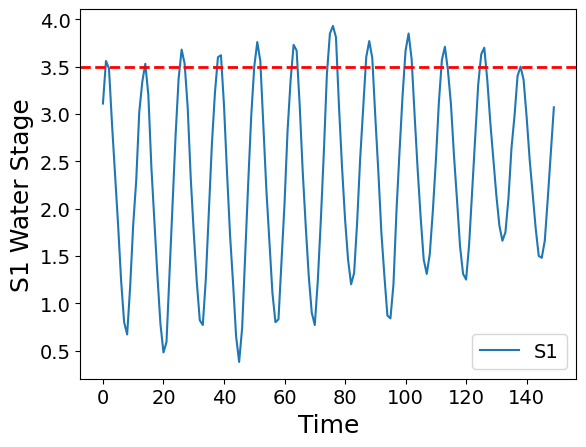

In [9]:
plt.plot(ws1[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [15]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [16]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(150, 96, 7)
(100800,)


In [17]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(150, 96, 2)


In [18]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(150, 96, 3)


### GA

In [19]:
saved_model = load_model('../saved_models/WaLeF_gtn_p_1.h5', custom_objects={'GCNConv': GCNConv}, compile=False)
# load_model('cnn.h5', compile=False)

2023-08-07 23:50:02.573136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


In [20]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum 
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [21]:
fitness_function = fitness_func

num_generations = 500
num_parents_mating = 32

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [22]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [23]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-07 23:50:39.376708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step
CPU time: 9765.087827380048 seconds


In [24]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

5/5 [==============================] - 0s 3ms/step
Parameters of the best solution : [0.42794393 0.87876908 0.42803113 ... 0.26478785 0.84275406 0.57731464]
Fitness value of the best solution = 5.537596182293107e-05


### Post-processing

In [25]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

5/5 [==============================] - 0s 3ms/step


In [26]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

2070


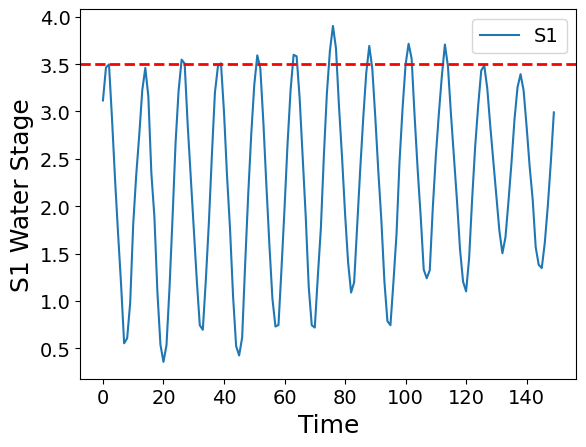

In [27]:
plt.plot(best_perf[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [28]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event5.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.427944,0.878769,0.428031,0.287774,0.082494,0.379447,0.862053,0.491107,0.452832,0.332721,...,0.512081,0.683344,0.396487,0.366702,0.198904,0.392156,0.234375,0.207270,0.424526,0.259148
1,0.064128,0.835464,0.640117,0.984965,0.496416,0.407925,0.870925,0.873209,0.162316,0.194588,...,0.494226,0.389024,0.571617,0.395021,0.160615,0.181007,0.071002,0.525793,0.626887,0.767342
2,0.188353,0.801734,0.884759,0.731080,0.747818,0.985742,0.340767,0.131063,0.566532,0.095136,...,0.343386,0.599428,0.458658,0.544586,0.817065,0.699310,0.627115,0.184386,0.270035,0.555344
3,0.305512,0.978695,0.051215,0.701514,0.821896,0.663967,0.731950,0.021658,0.131352,0.597850,...,0.318189,0.308399,0.614228,0.876712,0.987967,0.133578,0.000324,0.675389,0.808200,0.668132
4,0.408793,0.774700,0.883208,0.051019,0.214536,0.059344,0.461093,0.443346,0.973741,0.618010,...,0.976947,0.536046,0.430048,0.835077,0.589496,0.732399,0.320991,0.709808,0.676590,0.678588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.399253,0.873086,0.267899,0.982534,0.098872,0.430387,0.011635,0.191647,0.306653,0.019629,...,0.959455,0.811642,0.399410,0.704206,0.527097,0.273782,0.379249,0.243341,0.433840,0.644267
146,0.192377,0.375686,0.971318,0.330262,0.468080,0.169818,0.979007,0.376511,0.286736,0.306978,...,0.385737,0.121977,0.793130,0.825809,0.633327,0.775412,0.587190,0.639463,0.157870,0.038820
147,0.223867,0.456956,0.838262,0.415526,0.941436,0.211971,0.383354,0.856891,0.257192,0.112296,...,0.789612,0.194957,0.161769,0.712635,0.177623,0.770594,0.733092,0.339939,0.519783,0.739982
148,0.359296,0.654216,0.619807,0.985132,0.523442,0.376850,0.761827,0.793778,0.439238,0.887844,...,0.295901,0.231995,0.080976,0.227399,0.501580,0.946648,0.763450,0.834370,0.972428,0.608375


In [29]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event5.csv", index=False)
# Optimal_case = pd.read_csv("GA_results/best_performance_event5.csv")
# Optimal_case

In [30]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)

time steps: 2070, areas: 416.43702960014343
time steps: 0, areas: 0


In [31]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

5/5 [==============================] - 0s 3ms/step
time steps: 2217, areas: 454.9783124923706
time steps: 0, areas: 0
